# Python modules for marker / motion-capture datasets

This Jupyter notebook is part of the *Python programming for the movement sciences* to give you a crude introduction to 
toolboxes that you can use for data collected from optical motion capture systems (e.g. marker, force plate, or electromyography data). 
This seminar is hardly enough for you to master these toolboxes, but it provides the basic knowledge needed to get started. <br>
The commands shown here are universal across all platforms (mac os/windows/linux), across programming IDEs or programming notebooks.

This notebook will explore the following modules 
- [ezc3d](https://github.com/pyomeca/ezc3d): read/write c3d files (actually part of pyomeca...)
- [Pyomeca](https://pyomeca.github.io/): biomechanical analysis toolbox 
- [kineticstoolkit](https://kineticstoolkit.uqam.ca/doc/): (another) biomechanical analysis toolbox 

In [4]:
# Import the necessary libraries
import ezc3d
import numpy as np
import matplotlib.pyplot as plt


## Loading c3d files (version 1: using ezc3d)
A crucial starting point is the ability to load standard motion capture file types such as c3d files. We will start by using ezc3d to open a file called ``gait-pig.c3d`` available in our repository. 


In [9]:
# Load a C3D file
c3d_file_path = 'gait-pig.c3d'  # Replace with your .c3d file path
c3d = ezc3d.c3d(c3d_file_path)

ezc3d.c3d

### How to access specific marker data or joint angle from the loaded file

The following demonstrates that once you load a file with ezc3d, you still have some work to do to organize the data the way you 
want it. Here, we create a dictionary called ``data`` allowing us access to the trajectories for plotting.  

In [10]:
# Extract labels and corresponding data from a c3d file (likely motion capture data)

# Get a list of all point parameters
points=list(c3d['parameters']['POINT'].keys())

# Find indices of point parameters that contain the word 'LABELS'
LABELS=np.where(np.char.find(points,'LABELS')==0)[0]

# Extract the first set of labels
label=np.array(c3d['parameters']['POINT'][points[LABELS[0]]]['value'])

# If there are multiple sets of labels, append them to the 'label' array
if LABELS.shape[0]>1:
    for LABEL in range(1,LABELS.shape[0]):
        label=np.append(label,
                        np.array(c3d['parameters']['POINT'][points[LABELS[LABEL]]]['value']))

# Extract the 3D point data for each label
label_data=c3d['data']['points'][0:3,:,:]

# Create a dictionary to store the label and corresponding data
data={}
for i in range(len(label)):
    data[f"{label[i]}"]=label_data[:,i,:]

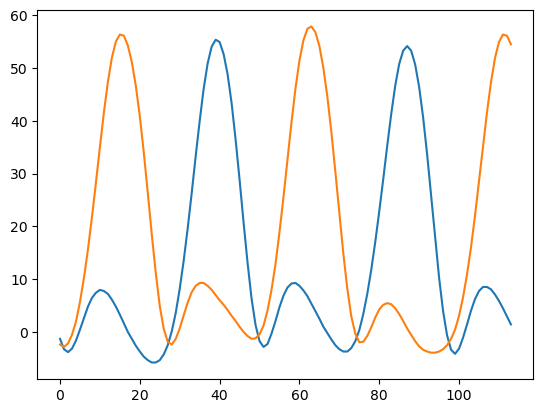

In [11]:
# Plot the right knee angles over time.
plt.plot(data['A22:RKneeAngles'][0,:]) 
# Plot the left knee angles over time.
plt.plot(data['A22:LKneeAngles'][0,:]) 


### How to access events stored in c3d file

In addition to trajectory data, users may want to access events (e.g. for gait, the timing of foot strike is often important). Again, a short script can be created to help us extract this information and print it.

In [12]:
# Initialize a dictionary to store events for left and right limbs
events={'Right':{'Foot Strike':[],'Foot Off':[]},'Left':{'Foot Strike':[],'Foot Off':[]}}

# Extract context, event names, and timestamps from the c3d data
contexts=np.array(c3d['parameters']['EVENT']['CONTEXTS']['value'])  # Limb (Right/Left)
eventname=np.array(c3d['parameters']['EVENT']['LABELS']['value'])   # Event type (Foot Strike/Foot Off)
# Calculate event times in seconds, adjusting for trial start time and camera rate
values=np.array(c3d['parameters']['EVENT']['TIMES']['value'][1]*c3d['parameters']['TRIAL']['CAMERA_RATE']['value'])

# Populate the events dictionary
for i in range(len(contexts)):
    # Subtract trial start time to get relative time from trial start
    events[contexts[i]][eventname[i]].append(round(values[i]-c3d['parameters']['TRIAL']['ACTUAL_START_FIELD']['value'][0])) 

# Sort events for each limb and event type
for j in events.keys():
    for i in events[j].keys():
        events[j][i]=np.sort(events[j][i])

In [6]:
events

{'Right': {'Foot Strike': array([51, 99]), 'Foot Off': array([ 80, 129])},
 'Left': {'Foot Strike': array([ 27,  75, 123]),
  'Foot Off': array([ 57, 105])}}

## Loading c3d files (version 2: using kineticstoolkit)

The kineticstoolkit can also be used to load a c3d file. As we will see below, the advantage is that users can more readily access data without developing additional scripts. Users can plot data using a single line. We will see later that the kinetictoolkit can do much more than just open c3d files


In [16]:
import kineticstoolkit.lab as ktk

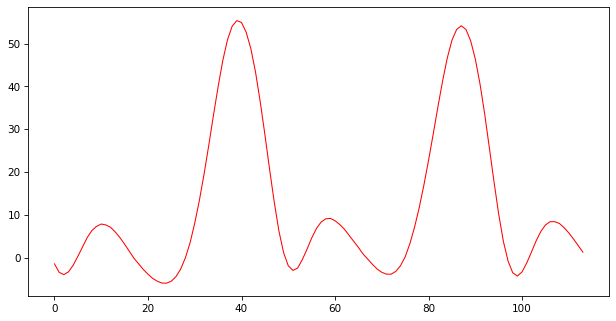

In [24]:
# Read the C3D file data into a variable 'c3d_contents'
# 'ktk.read_c3d()' is a function that reads a C3D file and returns its contents
c3d_file_path = 'gait-pig.c3d'  # Replace with your .c3d file path

c3d_contents = ktk.read_c3d(c3d_file_path, convert_point_unit=True)

# Plot the data for the 'RKneeAngles' point in the first dimension (x-axis).
# 'Points' is a key in the 'c3d_contents' dictionary containing kinematic data.
# '.data['A22:RKneeAngles'][:, 0]' extracts the x-axis data (first dimension) of the 'RKneeAngles' point.
# '*1000' is used to scale the data (e.g., converting meters to millimeters).
plt.plot(c3d_contents['Points'].data['A22:RKneeAngles'][:,0]*1000)


## Loading c3d files (version 3: using pyomeca)

Pyomeca can also be used to load a c3d file. As with the kineticstoolkit, it provides a bunch of methods allowing easy access to data. Here we show a neat feature that pyomeca provides out of the box. We can remove the subject name (A22) from the channel. This is often an annoyance to keep when trying to analyze the same kinematic channel across multiple subjects.

In [26]:
import pyomeca #import pyomeca library
from pyomeca import Markers #import Markers class from pyomeca library

data_path = "gait-pig.c3d" #specify the data path
markers = Markers.from_c3d(data_path,prefix_delimiter=':') #load markers data from c3d file and set prefix delimiter to ":"
#The prefix_delimiter argument is used to specify the character that separates the prefix from the marker name in the C3D file. 
#By setting the prefix_delimiter, Pyomeca can correctly parse the marker names and extract the relevant data.


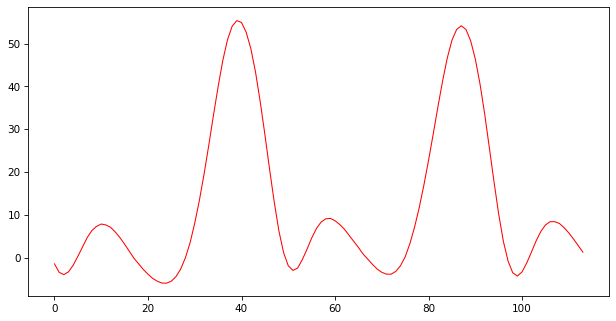

In [28]:
# Select data for the right knee angle and plot it.
plt.plot(markers.sel(axis='x',channel='RKneeAngles'))  
# .sel is used to select data based on coordinate values. In this case, it selects data for the channel labeled 'RKneeAngles'.
# The axis='x' extracts the flexion angles of the data for the selected channel

## Kinetics toolkit for biomechanical analysis

Here we demonstrate a useful feature of the kinetictoolkit: visualization. This is useful if you are making changes to your data and 
want to visualize it without having to export to a third party viewer (e.g. visual3d, mokka)

In [ ]:
# Set an interactive backend
%matplotlib qt5

In [34]:
# Read the 3D motion capture data from a C3D file named 'gait-pig.c3d'
# The 'read_c3d' function from the 'ktk' module reads the file and returns a dictionary.
# We extract the "Points" key from this dictionary, which contains the marker positions.
markers = ktk.read_c3d('gait-pig.c3d')["Points"]

# Create a Player object from the 'ktk' module using the marker data.
# The Player object is typically used to visualize or interact with the motion capture data.
p = ktk.Player(markers)


In [ ]:
# Play the animation or visualization of the marker data.
p.play()

# Example of multiple participants in a single file

In [15]:
# Download the kinematics data file for tennis serve involving 2 players and save the filename
filename = ktk.doc.download("kinematics_tennis_serve_2players.c3d")

# Read the downloaded C3D file and extract the "Points" data, which typically represents marker positions in 3D space
markers = ktk.read_c3d(filename)["Points"]

# Create a Player object using the extracted marker data
p = ktk.Player(markers)

# Play or visualize the motion using the Player object
#p.play()


In [16]:
# Create an empty dictionary to store the interconnections of body parts
interconnections = dict()

# Define interconnections for the "LLowerLimb" (left lower limb)
interconnections["LLowerLimb"] = {
    "Color": (0, 0.5, 1),  # The color associated with this limb in (R, G, B) format (here, greenish blue)
    "Links": [  # List of connections that represent lines between specified markers on the limb
        ["Derrick:LTOE", "Derrick:LHEE", "Derrick:LANK", "Derrick:LTOE"], # Connection path from left toe, heel, ankle, and back to toe
        ["Derrick:LANK", "Derrick:LKNE", "Derrick:LASI"], # Connection path from left ankle, knee, to anterior superior iliac spine (hip)
        ["Derrick:LKNE", "Derrick:LPSI"], # Connection from left knee to posterior superior iliac spine (back of the hip)
    ],
}
p.set_interconnections(interconnections)

In [17]:
# Define interconnections for different body parts, specifying their color and links between specific markers.
interconnections["RLowerLimb"] = {
    "Color": (0, 0.5, 1),  # Color for the right lower limb (in RGB format: cyan)
    "Links": [
        # Define links (connections) between the specified markers
        ["Derrick:RTOE", "Derrick:RHEE", "Derrick:RANK", "Derrick:RTOE"],  # Right foot loop
        ["Derrick:RANK", "Derrick:RKNE", "Derrick:RASI"],  # Lower leg connection
        ["Derrick:RKNE", "Derrick:RPSI"],  # Upper leg connection
    ],
}

interconnections["LUpperLimb"] = {
    "Color": (0, 0.5, 1),  # Color for the left upper limb (in RGB format: cyan)
    "Links": [
        # Define links between the specified markers for the left arm
        ["Derrick:LSHO", "Derrick:LELB", "Derrick:LWRA", "Derrick:LFIN"],  # Shoulder to fingers
        ["Derrick:LELB", "Derrick:LWRB", "Derrick:LFIN"],  # Elbow to wrist and fingers
        ["Derrick:LWRA", "Derrick:LWRB"],  # Wrist connection
    ],
}

interconnections["RUpperLimb"] = {
    "Color": (1, 0.5, 0),  # Color for the right upper limb (in RGB format: orange)
    "Links": [
        # Define links between the specified markers for the right arm
        ["Derrick:RSHO", "Derrick:RELB", "Derrick:RWRA", "Derrick:RFIN"],  # Shoulder to fingers
        ["Derrick:RELB", "Derrick:RWRB", "Derrick:RFIN"],  # Elbow to wrist and fingers
        ["Derrick:RWRA", "Derrick:RWRB"],  # Wrist connection
    ],
}

interconnections["Head"] = {
    "Color": (1, 0.5, 1),  # Color for the head (in RGB format: magenta)
    "Links": [
        # Define links between the specified markers for the head
        ["Derrick:C7", "Derrick:LFHD", "Derrick:RFHD", "Derrick:C7"],  # Head loop (front)
        ["Derrick:C7", "Derrick:LBHD", "Derrick:RBHD", "Derrick:C7"],  # Head loop (back)
        ["Derrick:LBHD", "Derrick:LFHD"],  # Left side of the head
        ["Derrick:RBHD", "Derrick:RFHD"],  # Right side of the head
    ],
}

interconnections["TrunkPelvis"] = {
    "Color": (0.5, 1, 0.5),  # Color for the trunk and pelvis (in RGB format: light green)
    "Links": [
        # Define links between the specified markers for the trunk and pelvis
        ["Derrick:LASI", "Derrick:STRN", "Derrick:RASI"],  # Anterior pelvis to sternum
        ["Derrick:STRN", "Derrick:CLAV"],  # Sternum to clavicle
        ["Derrick:LPSI", "Derrick:T10", "Derrick:RPSI"],  # Posterior pelvis to T10 vertebra
        ["Derrick:T10", "Derrick:C7"],  # T10 vertebra to C7 vertebra
        ["Derrick:LASI", "Derrick:LSHO", "Derrick:LPSI"],  # Left pelvis to left shoulder loop
        ["Derrick:RASI", "Derrick:RSHO", "Derrick:RPSI"],  # Right pelvis to right shoulder loop
        [
            "Derrick:LPSI",
            "Derrick:LASI",
            "Derrick:RASI",
            "Derrick:RPSI",
            "Derrick:LPSI",
        ],  # Pelvis loop
        [
            "Derrick:LSHO",
            "Derrick:CLAV",
            "Derrick:RSHO",
            "Derrick:C7",
            "Derrick:LSHO",
        ],  # Shoulder and clavicle loop
    ],
}

# Set the defined interconnections using the p.set_interconnections() function.
p.set_interconnections(interconnections)


In [18]:
import kineticstoolkit.lab as ktk

# Download and read markers from a sample C3D file
filename = ktk.doc.download("kinematics_tennis_serve_2players.c3d")
markers = ktk.read_c3d(filename)["Points"]
interconnections = dict()  # Will contain all segment definitions
interconnections["LLowerLimb"] = {
    "Color": (0, 0.5, 1),  # In RGB format (here, greenish blue)
    "Links": [  # List of lines that span lists of markers
        ["*LTOE", "*LHEE", "*LANK", "*LTOE"],
        ["*LANK", "*LKNE", "*LASI"],
        ["*LKNE", "*LPSI"],
    ],
}
interconnections["RLowerLimb"] = {
    "Color": (0, 0.5, 1),
    "Links": [
        ["*RTOE", "*RHEE", "*RANK", "*RTOE"],
        ["*RANK", "*RKNE", "*RASI"],
        ["*RKNE", "*RPSI"],
    ],
}
interconnections["LUpperLimb"] = {
    "Color": (0, 0.5, 1),
    "Links": [
        ["*LSHO", "*LELB", "*LWRA", "*LFIN"],
        ["*LELB", "*LWRB", "*LFIN"],
        ["*LWRA", "*LWRB"],
    ],
}
interconnections["RUpperLimb"] = {
    "Color": (1, 0.5, 0),
    "Links": [
        ["*RSHO", "*RELB", "*RWRA", "*RFIN"],
        ["*RELB", "*RWRB", "*RFIN"],
        ["*RWRA", "*RWRB"],
    ],
}
interconnections["Head"] = {
    "Color": (1, 0.5, 1),
    "Links": [
        ["*C7", "*LFHD", "*RFHD", "*C7"],
        ["*C7", "*LBHD", "*RBHD", "*C7"],
        ["*LBHD", "*LFHD"],
        ["*RBHD", "*RFHD"],
    ],
}
interconnections["TrunkPelvis"] = {
    "Color": (0.5, 1, 0.5),
    "Links": [
        ["*LASI", "*STRN", "*RASI"],
        ["*STRN", "*CLAV"],
        ["*LPSI", "*T10", "*RPSI"],
        ["*T10", "*C7"],
        ["*LASI", "*LSHO", "*LPSI"],
        ["*RASI", "*RSHO", "*RPSI"],
        ["*LPSI", "*LASI", "*RASI", "*RPSI", "*LPSI"],
        ["*LSHO", "*CLAV", "*RSHO", "*C7", "*LSHO"],
    ],
}
p = ktk.Player(
    markers,
    interconnections=interconnections,
    up="z",
    anterior="-y",
    target=(0, 0.5, 1),
    azimuth=0.1,
    zoom=1.5, 
)

In [9]:
markers.channel

<xarray.DataArray 'channel' (channel: 77)> Size: 6kB
array(['RKNE', 'LKNE', 'RTIB', 'LTHI', 'RTHI', 'LTIB', 'LTOE', 'RANK', 'LANK',
       'RASI', 'LASI', 'RTOE', 'SACR', 'LHipAngles', 'LKneeAngles',
       'LAnkleAngles', 'RHipAngles', 'RKneeAngles', 'RAnkleAngles',
       'LPelvisAngles', 'RPelvisAngles', 'LFootProgressAngles',
       'RFootProgressAngles', 'LHipPower', 'LKneePower', 'LAnklePower',
       'RHipPower', 'RKneePower', 'RAnklePower', 'LAnkleMoment', 'LAnkleForce',
       'RAnkleMoment', 'RAnkleForce', 'RKneeMoment', 'RKneeForce',
       'LKneeMoment', 'LKneeForce', 'RHipMoment', 'RHipForce', 'LHipMoment',
       'LHipForce', 'PELO', 'PELP', 'PELA', 'PELL', 'LFEO', 'LFEP', 'LFEA',
       'LFEL', 'LTIO', 'LTIP', 'LTIA', 'LTIL', 'LFOO', 'LFOP', 'LFOA', 'LFOL',
       'LTOO', 'LTOP', 'LTOA', 'LTOL', 'RFEO', 'RFEP', 'RFEA', 'RFEL', 'RTIO',
       'RTIP', 'RTIA', 'RTIL', 'RFOO', 'RFOP', 'RFOA', 'RFOL', 'RTOO', 'RTOP',
       'RTOA', 'RTOL'], dtype='<U19')
Coordinates:
  * channel  (channel) <U19 6kB 'RKNE' 'LKNE' 'RTIB' ... 'RTOP' 'RTOA' 'RTOL'

# How to procces EMG data using Pyomeca

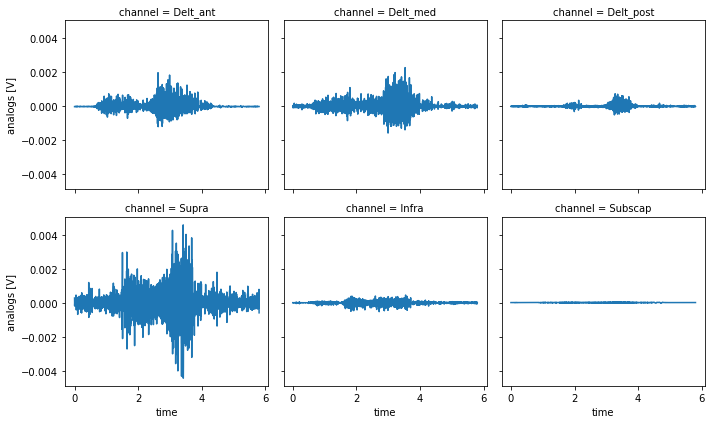

In [10]:
from pyomeca import Analogs # import Analogs class from pyomeca library

# path to c3d file containing emg data
data_path = "markers_analogs.c3d"

# list of muscles to extract from c3d file
muscles = [
    "Delt_ant",
    "Delt_med",
    "Delt_post",
    "Supra",
    "Infra",
    "Subscap",
] 

# create Analogs object from c3d file
emg = Analogs.from_c3d(data_path, suffix_delimiter=".", usecols=muscles) 

# plot emg data
emg.plot(x="time", col="channel", col_wrap=3) 


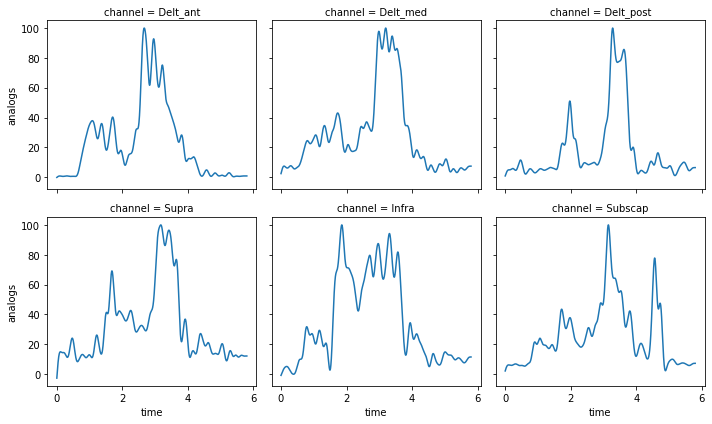

In [11]:
# Process EMG signal
emg_processed = (
    emg
    .meca.band_pass(order=2, cutoff=[10, 425])  # Apply band-pass filter to remove noise and focus on relevant frequencies
    .meca.center()  # Center the signal around zero
    .meca.abs()  # Take the absolute value to rectify the signal
    .meca.low_pass(order=4, cutoff=5, freq=emg.rate)  # Apply low-pass filter to smooth the signal
    .meca.normalize()  # Normalize the signal to a common range
)

# Plot processed EMG signal
emg_processed.plot(x="time", col="channel", col_wrap=3)

# - .meca commands are part of a library that provides signal processing functionalities.
# - .meca.band_pass: Applies a band-pass filter to the signal.
# - .meca.center: Centers the signal around zero.
# - .meca.abs: Calculates the absolute value of the signal.
# - .meca.low_pass: Applies a low-pass filter to the signal.
# - .meca.normalize: Normalizes the signal to a common range.

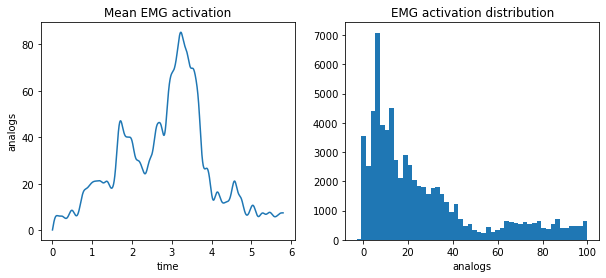

In [12]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

# Plot the mean EMG activation over all channels
emg_processed.mean("channel").plot(ax=axes[0])
axes[0].set_title("Mean EMG activation")

# Plot the histogram of EMG activation values
emg_processed.plot.hist(ax=axes[1], bins=50)
axes[1].set_title("EMG activation distribution")

# Display the plot
plt.show()

# How to Time Normalize data using Pyomeca

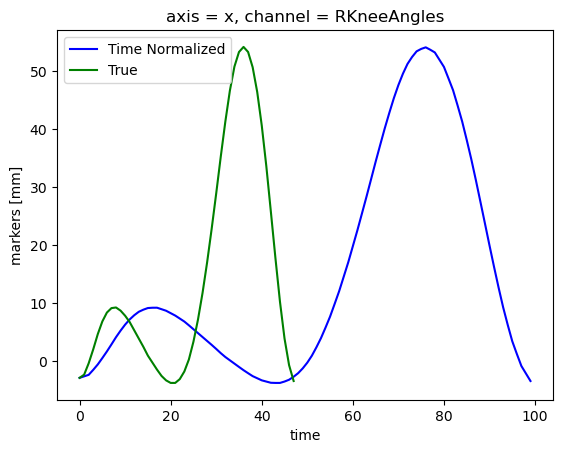

In [24]:
# Select the 'RKneeAngles' data from the markers, specifically along the 'x' axis
RKneeangles = markers.sel(axis='x', channel='RKneeAngles')

# Time normalize the selected RKneeAngles data between indices 51 and 99 (Both indices are foot strikes from events)
# 'norm_time=True' ensures the data is normalized with respect to time (0 to 1)
time_normalized = RKneeangles[51:99].meca.time_normalize(norm_time=True)

# Plot the time-normalized knee angle data
time_normalized.plot(color='b')

# Plot the original (true) knee angle data for comparison in green ('g')
plt.plot(RKneeangles.data[51:99], 'g')

# Add a legend to distinguish between the time-normalized data and the original data
plt.legend(['Time Normalized', 'True'])

# Display the plot with both curves
plt.show()
